In [43]:
import os # operating system
import pandas as pd
import shutil # shell utilities
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras import layers
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.utils import image_dataset_from_directory
import seaborn as sns
import plotly.express as px

notes for me; there are two ways that we can use pretrained models to make things easier

* feature extraction, which freezes the pretrained layers and adds a new classification layer at the end
    this method is fast and simple, and works well with small-medium datasets

* fine-tuning, which unfreezes some of the top layers so they can update their understanding of the data
    this method takes takes more time and is more advanced, but usually leads to better performance

In [3]:
csvPath = 'harData/Training_set.csv'
df = pd.read_csv(csvPath)

print("Preview of the dataset:")
print(df.head())

Preview of the dataset:
      filename         label
0  Image_1.jpg       sitting
1  Image_2.jpg  using_laptop
2  Image_3.jpg       hugging
3  Image_4.jpg      sleeping
4  Image_5.jpg  using_laptop


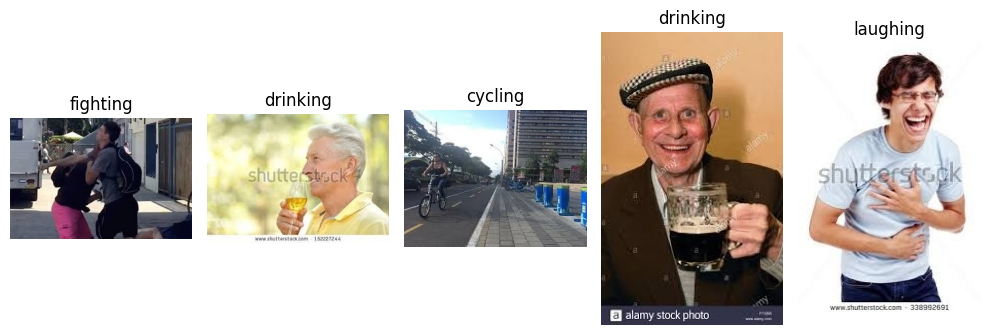

In [33]:
imageFolder = 'harData/train_sorted'
plt.figure(figsize=(10, 6))
randomSample = df.sample(n=5)

for i, (_, row) in enumerate(randomSample.iterrows()): # randomly displays 5 photos in the dataset
    imgPath = os.path.join(imageFolder, row['label'], row['filename'])
    label = row['label']
    image = Image.open(imgPath) # uses pil to open the data

    ax = plt.subplot(1, 5, i + 1)
    plt.imshow(image)
    plt.title(label)
    plt.axis("off")

plt.tight_layout()
plt.show()

In [39]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

trainDS = tf.keras.utils.image_dataset_from_directory(
    imageFolder,
    image_size =(224, 224), # image resizing
    batch_size = 32,
    label_mode = 'categorical', # enables one-hot encoding
    shuffle = True
)

# note; image_size, batch_size, and label_mode are NOT user-made variables

Found 12600 files belonging to 15 classes.


note to self; trainDS automatically allows tf to read, resize, encode, and batch the images for training

unfortunately, normalization still has to be applied manually :sweat:

In [40]:
classNames = trainDS.class_names
print("Class Labels:")
for i, className in enumerate(classNames, 1):
    print(f"{i}. {className}")

Class Labels:
1. calling
2. clapping
3. cycling
4. dancing
5. drinking
6. eating
7. fighting
8. hugging
9. laughing
10. listening_to_music
11. running
12. sitting
13. sleeping
14. texting
15. using_laptop


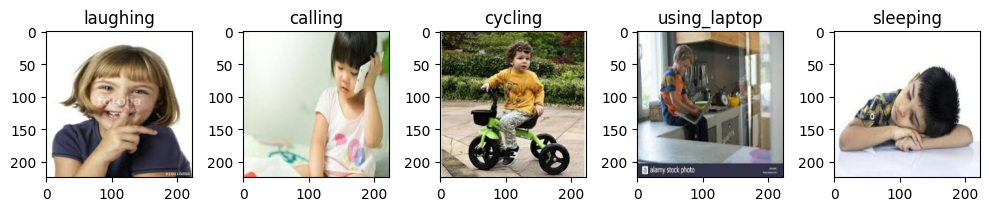

In [ ]:
# note; this double checks to make sure tf loaded the images right

plt.figure(figsize=(10,6))
for images, labels in trainDS.take(1):
    for i in range(5):
        ax = plt.subplot(1, 5, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(classNames[labels[i].numpy().argmax()]) 
        plt.axis = "off"
plt.tight_layout()
plt.show()

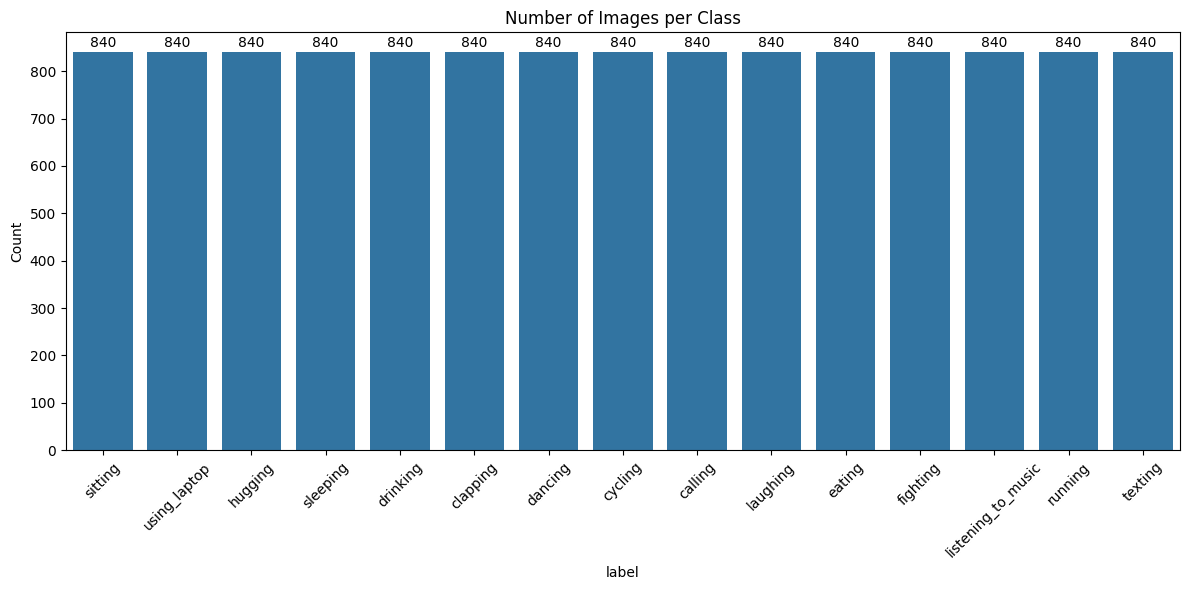

In [42]:
classCounts = df['label'].value_counts()

plt.figure(figsize=(12,6))
ax = sns.barplot(x = classCounts.index, y = classCounts.values)
plt.title("Number of Images per Class")
plt.ylabel("Count")
plt.xticks(rotation = 45)

for bar in ax.patches:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height + 5,
        int(height),
        ha = 'center', va='bottom'
    )

plt.tight_layout()
plt.show()

In [ ]:
# loading the pretrained model so that i can start transfer learning

baseModel = MobileNetV2(
    input_shape = (224, 224, 3),
    include_top = False,
    weights = 'imagenet'
)

baseModel.trainable = False

model = Sequential([
    baseModel,
    GlobalAveragePooling2D(),
    Dropout(0.3),
    Dense(128, activation = 'relu'),
    Dense(15, activation = 'softmax')
])

# note; input_shape and include_top are NOT user-made variables

In [51]:
model.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

model.summary()
print("Model compiled and ready to train!")

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 15)             │         1,935 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,423,887 (9.25 MB)

 Trainable params: 165,903 (648.06 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Model compiled and ready to train!


In [54]:
valDS = trainDS.take(20)
trainDS = trainDS.skip(20)

history = model.fit(
    trainDS,
    validation_data = valDS,
    epochs = 5
)

# note; validation_data is NOT a user-made variable

Epoch 1/5
354/354 ━━━━━━━━━━━━━━━━━━━━ 214s 566ms/step - accuracy: 0.1521 - loss: 2.6090 - val_accuracy: 0.2641 - val_loss: 2.2479
Epoch 2/5
354/354 ━━━━━━━━━━━━━━━━━━━━ 182s 514ms/step - accuracy: 0.2713 - loss: 2.2320 - val_accuracy: 0.3250 - val_loss: 2.1148
Epoch 3/5
354/354 ━━━━━━━━━━━━━━━━━━━━ 190s 536ms/step - accuracy: 0.2990 - loss: 2.1475 - val_accuracy: 0.3313 - val_loss: 2.0580
Epoch 4/5
354/354 ━━━━━━━━━━━━━━━━━━━━ 223s 624ms/step - accuracy: 0.3125 - loss: 2.1004 - val_accuracy: 0.3406 - val_loss: 2.0396
Epoch 5/5
354/354 ━━━━━━━━━━━━━━━━━━━━ 174s 492ms/step - accuracy: 0.3270 - loss: 2.0534 - val_accuracy: 0.3453 - val_loss: 1.9893
